# Linear Regression for Origin and Sides

Идея в том, что подход в лоб подразумевает построение регрессии, чтобы предсказать координаты прямоугольника. Кажетсся, что полученная на основе подобных предсказаний оценка положения центра прямоугольнка будет менее шумной.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats

In [2]:
from os.path import join

In [3]:
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
from mlbootcamp.rnd21.bbox_regression import BoundingBoxRegressor
from mlbootcamp.rnd21.util import iou, miou

Загрузим данные.

In [5]:
DATADIR = '../../data/round/21'

In [6]:
user = pd.read_parquet(join(DATADIR, 'train_data.parquet')) \
    .set_index(['item_id', 'user_id']) \
    .sort_index()
true = pd.read_parquet(join(DATADIR, 'train_ans.parquet')) \
    .set_index('item_id') \
    .sort_index()

Обучим регрессор на всех данных и применим тоже ко всем данным, что не очень корректно, так как все выводы будут смещены к завышению целевой метрике.

In [7]:
reg = BoundingBoxRegressor(
    denoising=False,
).fit(user.reset_index().copy(), true.reset_index().copy())

In [8]:
pred = reg.predict(user.reset_index()).set_index('item_id')
pred.head()

,x_min,y_min,x_max,y_max
item_id,,,,
5,117.029505,928.058811,524.577536,1287.084254
10,80.107715,568.217123,416.471435,842.299116
13,89.746040,605.254701,569.010876,996.667290
30,72.050067,353.691004,299.382133,512.130942
32,32.658963,324.641134,464.608755,710.183106


## Линейная регрессия по центрам прямоугольников

In [9]:
def centering(row):
    return 0.5 * (row.x_min + row.x_max), 0.5 * (row.y_min + row.y_max)

In [10]:
concur = pred.copy()
concur[['x_cent', 'y_cent']] = concur.apply(centering, axis=1, result_type='expand')
concur.head()

,x_min,y_min,x_max,y_max,x_cent,y_cent
item_id,,,,,,
5,117.029505,928.058811,524.577536,1287.084254,320.803521,1107.571533
10,80.107715,568.217123,416.471435,842.299116,248.289575,705.258120
13,89.746040,605.254701,569.010876,996.667290,329.378458,800.960995
30,72.050067,353.691004,299.382133,512.130942,185.716100,432.910973
32,32.658963,324.641134,464.608755,710.183106,248.633859,517.412120


In [11]:
data = user.copy()
data[['x_cent', 'y_cent']] = data.apply(centering, axis=1, result_type='expand')
data = data \
    .groupby('item_id') \
    .aggregate({'x_min': np.min,
                'y_min': np.min,
                'x_max': np.max,
                'y_max': np.max,
                'x_cent': np.mean,
                'y_cent': np.mean})
data.head()

,x_min,y_min,x_max,y_max,x_cent,y_cent
item_id,,,,,,
5,151,914,511,1331,342.833333,1083.666667
10,72,559,427,858,252.000000,709.000000
13,46,600,621,981,333.166667,784.833333
30,65,353,324,491,180.300000,412.400000
32,9,279,388,884,142.166667,656.416667


In [12]:
target = true.copy()
target[['x_cent', 'y_cent']] = target.apply(centering, axis=1, result_type='expand')
target['dx'] = target.x_max - target.x_min
target['dy'] = target.y_max - target.y_min
target.head()

,x_min,y_min,x_max,y_max,x_cent,y_cent,dx,dy
item_id,,,,,,,,
5,198,827,649,1340,423.5,1083.5,451,513
10,26,605,433,847,229.5,726.0,407,242
13,233,698,622,920,427.5,809.0,389,222
30,61,368,329,530,195.0,449.0,268,162
32,30,536,328,813,179.0,674.5,298,277


## Предсказываем центр прямоугольника

Как и в общем случае есть несколько способов разобраться с множественными разметками на одну картинку: агреггировать пользовательские разметки, а затем обучить; обучить, а затем агреггировать предсказанные разметки. Как правило на данной задаче предварительная агрегация показывает лучший результат.

### С предварительной аггрегацией

Признаки размножены с помощью простейших полиномиальных и нелинейных преобразований.

In [13]:
def fit(data):
    train_item_ids, test_item_ids = train_test_split(target.index.values, train_size=0.7)

    data = data.copy().reset_index()
    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
    data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
    data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
    data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
    data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
    # data['dx/dy'] = data.width / (data.height + 1)
    # data['dy/dx'] = data.height / (data.width + 1)
    data = data.set_index('item_id')

    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]

    loc = LinearRegression(
        normalize=True,
    ).fit(train_data.values, train_target[['x_cent', 'y_cent']].values)

    pred_target = test_target.copy()
    pred_target[['x_cent', 'y_cent']] = loc.predict(test_data.values)

    coord_real = test_target[['x_cent', 'y_cent']].values
    coord_pred = pred_target[['x_cent', 'y_cent']].values
    coord_conc = concur.loc[test_item_ids, ['x_cent', 'y_cent']].values

    cent_norms = np.linalg.norm(coord_real - coord_pred, axis=1)
    print('cent:', np.mean(cent_norms), np.std(cent_norms), np.median(cent_norms))

    conc_norms = np.linalg.norm(coord_real - coord_conc, axis=1)
    print('best:', np.mean(conc_norms), np.std(conc_norms), np.median(conc_norms))
    return cent_norms, conc_norms

In [14]:
for _ in range(3):
    cent_norms, conc_norms = fit(data)
    print()

cent: 59.02261040332015 48.096954211092104 43.73182070146992
best: 58.30576726822878 46.482236343500865 41.71147386365696

cent: 54.04523170601841 44.8794372809149 39.62737637676648
best: 53.72976848189364 44.21666059984945 39.92689463843603

cent: 55.88290002911885 47.596639765820726 42.79048182065192
best: 54.71554919368101 46.7017193080219 41.77427678697873



Сравниваемся с лучшим алгоритмом. Лучшим алгоритмом на данный момент является посроение линейной регрессии сразу по по четырём координатам прямоугольников.

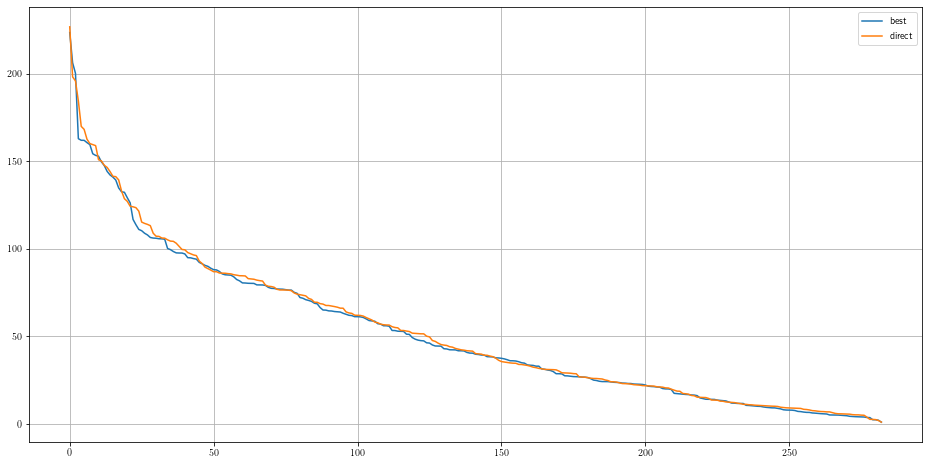

In [15]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 1, 1)
ax.plot(sorted(conc_norms, reverse=True), label='best')
ax.plot(sorted(cent_norms, reverse=True), label='direct')
ax.legend()
ax.grid()

plt.show()

### Без предварительной аггрегации

Здесь приходится сделать копию исходных данных, так как на предыдущей итерации разметки были агрегированы.

In [16]:
data = user.copy()
data[['x_cent', 'y_cent']] = data.apply(centering, axis=1, result_type='expand')
data.head()

x_min  y_min  x_max  y_max  x_cent  y_cent
item_id user_id                                            
5       141        210    925    483   1255   346.5  1090.0
        903        151    917    511   1160   331.0  1038.5
        1723       192    914    510   1331   351.0  1122.5
10      141         95    559    427    852   261.0   705.5
        903         72    570    420    858   246.0   714.0

In [17]:
def fit(data, target):
    train_item_ids, test_item_ids = train_test_split(target.index.values, train_size=0.7)
    
    target = target \
        .copy() \
        .drop(['x_min', 'y_min', 'x_max', 'y_max'], axis=1)

    data = data.copy().reset_index()
    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['x_min_y_min'] = data.x_min * data.y_min
    data['x_max_y_max'] = data.x_max * data.y_max
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
    data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
    data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
    data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
    data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
#     data['dx/dy'] = data.width / (data.height + 1)
#     data['dy/dx'] = data.height / (data.width + 1)
    data = data.set_index('item_id')

    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]
    train = pd.merge(train_data, train_target, left_index=True, right_index=True)

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]
    test = pd.merge(test_data, test_target, left_index=True, right_index=True)
    test = test.rename(columns={'x_cent_y': 'x_cent',
                                'y_cent_y': 'y_cent'})

    loc = LinearRegression(
        normalize=True,
    ).fit(train.values[:, :-2], train.values[:, -2:])

    pred_target = test[['x_cent', 'y_cent']].copy()
    pred_target[['x_cent', 'y_cent']] = loc.predict(test.values[:, :-2])
    
    coord_real = test_target[['x_cent', 'y_cent']].values
    coord_conc = concur.loc[test_item_ids, ['x_cent', 'y_cent']].values
    coords = pd.merge(pred_target, test_target, left_index=True, right_index=True) \
        .groupby('item_id') \
        .mean()
    coords['norm'] = np.linalg.norm(coords.values[:, :2] - coords.values[:, 2:], axis=1)

    conc_norms = np.linalg.norm(coord_real - coord_conc, axis=1)
    print(f'best: {np.mean(conc_norms):.3f} ± {np.std(conc_norms):.3f}; {np.median(conc_norms):.3f}')

    cent_norms = coords['norm']
    print(f'cent: {np.mean(cent_norms):.3f} ± {np.std(cent_norms):.3f}; {np.median(cent_norms):.3f}')
    
    return cent_norms, conc_norms

In [18]:
for _ in range(3):
    cent_norms, conc_norms = fit(data, target)
    print()

best: 54.707 ± 44.644; 38.826
cent: 60.055 ± 47.220; 51.208

best: 51.919 ± 44.291; 37.401
cent: 57.615 ± 46.094; 44.297

best: 50.492 ± 40.714; 38.271
cent: 55.339 ± 43.578; 45.515



**NB** Агрегация предсказанных центров истинный прямоугольников не дала существенного выигрыша.

## Построение ансанбля моделей предсказания центра

Следующая идея связана с гипотезой, что алгоритмы, построенные на предыдущих стадиях ошибаются по разному, а значит ансамбль таких моделей может показать лучшее качество.

In [19]:
def fit_after(data, target, train_item_ids, test_item_ids):
    target = target \
        .copy() \
        .drop(['x_min', 'y_min', 'x_max', 'y_max'], axis=1)

    data = data.copy().reset_index()
    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['x_min_y_min'] = data.x_min * data.y_min
    data['x_max_y_max'] = data.x_max * data.y_max
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
    data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
    data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
    data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
    data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
#     data['dx/dy'] = data.width / (data.height + 1)
#     data['dy/dx'] = data.height / (data.width + 1)
    data = data.set_index('item_id')

    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]
    train = pd.merge(train_data, train_target, left_index=True, right_index=True)

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]
    test = pd.merge(test_data, test_target, left_index=True, right_index=True)
    test = test.rename(columns={'x_cent_y': 'x_cent',
                                'y_cent_y': 'y_cent'})

    loc = LinearRegression(
        normalize=True,
    ).fit(train.values[:, :-2], train.values[:, -2:])

    pred_target = test[['x_cent', 'y_cent']].copy()
    pred_target[['x_cent', 'y_cent']] = loc.predict(test.values[:, :-2])
    
    coord_real = test_target[['x_cent', 'y_cent']].values
    coords = pd.merge(pred_target, test_target, left_index=True, right_index=True) \
        .groupby('item_id') \
        .mean()
    coords = coords.rename(columns={'x_cent_x': 'x_cent', 'y_cent_x': 'y_cent'})
    return coords[['x_cent', 'y_cent']].copy().sort_index()


def fit_before(data, target, train_item_ids, test_item_ids):
    target = target.copy()
    data = data.copy().reset_index() \
        .groupby('item_id') \
        .aggregate({'x_min': np.min,
                    'y_min': np.min,
                    'x_max': np.max,
                    'y_max': np.max,
                    'x_cent': np.mean,
                    'y_cent': np.mean})

    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
    data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
    data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
    data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
    data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
    # data['dx/dy'] = data.width / (data.height + 1)
    # data['dy/dx'] = data.height / (data.width + 1)

    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]

    loc = LinearRegression(
        normalize=True,
    ).fit(train_data.values, train_target[['x_cent', 'y_cent']].values)

    pred_target = test_target.copy()
    pred_target[['x_cent', 'y_cent']] = loc.predict(test_data.values)
    return pred_target[['x_cent', 'y_cent']].copy().sort_index()


def fit(data, target):
    train_item_ids, test_item_ids = train_test_split(target.index.values, train_size=0.7)
    
    after = fit_after(data, target, train_item_ids, test_item_ids)
    before = fit_before(data, target, train_item_ids, test_item_ids)
    result = after.copy() \
        .append(before) \
        .sort_index() \
        .groupby('item_id') \
        .mean()
    
    coord_real = target.loc[result.index, ['x_cent', 'y_cent']].values
    coord_cent = result.loc[result.index, ['x_cent', 'y_cent']].values
    coord_best = concur.loc[result.index, ['x_cent', 'y_cent']].values

    norms_best = np.linalg.norm(coord_real - coord_best, axis=1)
    print(f'best: {np.mean(norms_best):.3f} ± {np.std(norms_best):.3f}; {np.median(norms_best):.3f}')

    norms_cent = np.linalg.norm(coord_real - coord_cent, axis=1)
    print(f'cent: {np.mean(norms_cent):.3f} ± {np.std(norms_cent):.3f}; {np.median(norms_cent):.3f}')
    
    return norms_best, norms_cent

In [20]:
for _ in range(3):
    cent_norms, conc_norms = fit(data, target)
    print()

best: 50.923 ± 41.937; 38.248
cent: 53.323 ± 44.740; 39.107

best: 52.489 ± 42.212; 38.248
cent: 54.080 ± 43.223; 43.362

best: 56.408 ± 45.204; 41.772
cent: 57.542 ± 46.574; 42.573



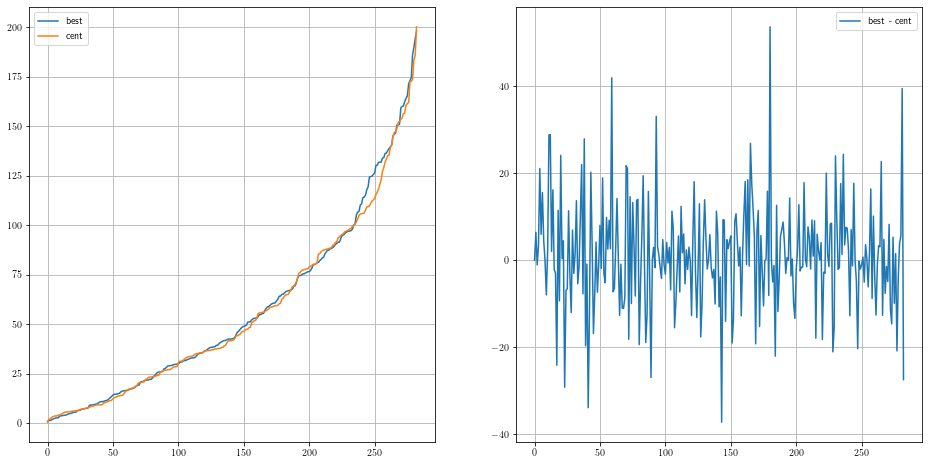

In [21]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1)
ax.plot(sorted(conc_norms, reverse=False), label='best')
ax.plot(sorted(cent_norms, reverse=False), label='cent')
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(conc_norms - cent_norms, label='best - cent')
ax.legend()
ax.grid()

plt.show()

**NB** Объединение результа работы двух алгоритмов никак не улучшает качество работы. Для аггрегации использовались различные функции: `mean()`, `max()` и `min()`. Разница норм лучшего на данный момент регрессора и регрессора, который напрямую предсказывает координаты центра прямоугольника, колеблется вокруг среднего значения, причём есть выбросы, которые возможно получится сгладить построения ансамбля всех моделей.

## Построение ансамбля

Возможно, что ансамблирование моделей предсказывающих центр и модели, которая предсказывает координаты бокса разом даст лучшее качество.

In [22]:
def fit_ensamble(data, target):
    train_item_ids, test_item_ids = train_test_split(target.index.values, train_size=0.7)
    
    after = fit_after(data, target, train_item_ids, test_item_ids)
    before = fit_before(data, target, train_item_ids, test_item_ids)
    result = concur.loc[test_item_ids, ['x_cent', 'y_cent']].copy() \
        .append([after, before]) \
        .sort_index() \
        .groupby('item_id') \
        .median()

    coord_real = target.loc[result.index, ['x_cent', 'y_cent']].values
    coord_best = concur.loc[result.index, ['x_cent', 'y_cent']].values
    coord_ens = result.loc[result.index, ['x_cent', 'y_cent']].values

    norms_best = np.linalg.norm(coord_real - coord_best, axis=1)
    print(f'best: {np.mean(norms_best):.3f} ± {np.std(norms_best):.3f}; {np.median(norms_best):.3f}')
    
    norms_ens = np.linalg.norm(coord_real - coord_ens, axis=1)
    print(f'ens: {np.mean(norms_ens):.3f} ± {np.std(norms_ens):.3f}; {np.median(norms_ens):.3f}')
    
    return norms_best, norms_ens

In [23]:
for _ in range(3):
    conc_norms, ens_norms = fit_ensamble(data, target)
    print()

best: 55.641 ± 45.907; 41.710
ens: 55.670 ± 46.153; 41.143

best: 48.328 ± 42.785; 32.999
ens: 48.266 ± 43.155; 33.209

best: 58.118 ± 48.034; 44.035
ens: 58.363 ± 48.135; 44.501



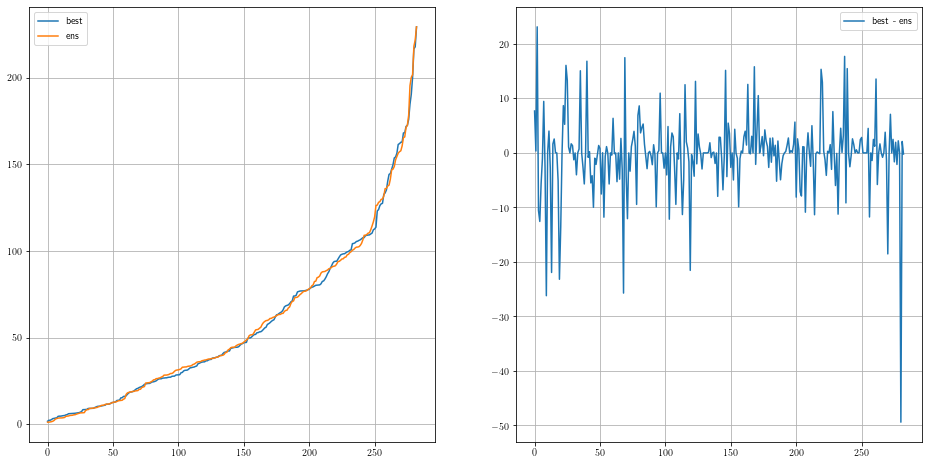

In [24]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, 1)
ax.plot(sorted(conc_norms, reverse=False), label='best')
ax.plot(sorted(ens_norms, reverse=False), label='ens')
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(conc_norms - ens_norms, label='best - ens')
ax.legend()
ax.grid()

plt.show()

**NB** Построение ансабля снова показывает себя хуже существующего алгоритма. Голосование средним и медианой лучше всего проявили себя. Выбросы остались, но в основном результаты ансамбля приблизилась к результатам регрессора прямоугольников.

## Регрессия сторон

Предположим, что у нас есть алгортм, предсказывающий положение центра прямоугольника, тогда, чтобы получить координаты прямоугольников, нужно ещё предсказать размеры сторон. Этим сейчас и займёмся.

In [25]:
def fit_origin(data, target, train_item_ids, test_item_ids):
    target = target.copy().sort_index()
    data = data.copy().reset_index() \
        .groupby('item_id') \
        .aggregate({'x_min': np.min,
                    'y_min': np.min,
                    'x_max': np.max,
                    'y_max': np.max,
                    'x_cent': np.mean,
                    'y_cent': np.mean})

    data = data.sort_index()
    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
    data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
    data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
    data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
    data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
    # data['dx/dy'] = data.width / (data.height + 1)
    # data['dy/dx'] = data.height / (data.width + 1)

    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]

    loc = LinearRegression(
        normalize=True,
    ).fit(train_data.values, train_target[['x_cent', 'y_cent']].values)

    pred_all = target.copy()
    pred_all[['x_cent', 'y_cent']] = loc.predict(data.values)
    return pred_all[['x_cent', 'y_cent']].copy().sort_index()

def fit_sides(data, origin, target, train_item_ids, test_item_ids):
    """Пытаемся предсказать стороны прямоугольника, зная положение центра.
    """
    target = target.copy()
    origin.copy()
    data = data.copy().reset_index() \
        .groupby('item_id') \
        .aggregate({'x_min': np.min,
                    'y_min': np.min,
                    'x_max': np.max,
                    'y_max': np.max,
                    'x_cent': np.mean,
                    'y_cent': np.mean})
    
    data = pd.merge(data, origin, left_index=True, right_index=True)
    data['x_min2'] = data.x_min ** 2
    data['y_min2'] = data.y_min ** 2
    data['x_max2'] = data.x_max ** 2
    data['y_max2'] = data.y_max ** 2
    data['ln_x_min'] = np.log(data.x_min + 4.5)
    data['ln_y_min'] = np.log(data.y_min)
    data['ln_x_max'] = np.log(data.x_max)
    data['ln_y_max'] = np.log(data.y_max)
#     data['exp_x_min'] = np.exp(np.minimum(data.x_min, 1e2))
#     data['exp_y_min'] = np.exp(np.minimum(data.y_min, 1e2))
#     data['exp_x_max'] = np.exp(np.minimum(data.x_max, 1e2))
#     data['exp_y_max'] = np.exp(np.minimum(data.y_max, 1e2))
    data['width'] = data.x_max - data.x_min
    data['height'] = data.y_max - data.y_min
    
    train_target = target.loc[train_item_ids]
    train_data = data.loc[train_item_ids]

    test_target = target.loc[test_item_ids]
    test_data = data.loc[test_item_ids]

    loc = LinearRegression(
        normalize=True,
    ).fit(train_data.values, train_target[['dx', 'dy']].values)

    pred_target = test_target.copy()
    pred_target[['dx', 'dy']] = loc.predict(test_data.values)
    return pred_target[['dx', 'dy']].copy().sort_index()

def fit(data, target):
    train_item_ids, test_item_ids = train_test_split(target.index.values, train_size=0.7)

    origin = fit_origin(data, target, train_item_ids, test_item_ids)    
    sides = fit_sides(data, origin, target, train_item_ids, test_item_ids)
    
    boxes = pd.merge(origin, sides, how='right', left_index=True, right_index=True)
    boxes['x_min'] = boxes.x_cent - boxes.dx / 2
    boxes['x_max'] = boxes.x_cent + boxes.dx / 2
    boxes['y_min'] = boxes.y_cent - boxes.dy / 2
    boxes['y_max'] = boxes.y_cent + boxes.dy / 2
    boxes = boxes.sort_index()

    lhs = boxes[['x_min', 'y_min', 'x_max', 'y_max']].values
    rhs = target.loc[test_item_ids] \
        .sort_index() \
        [['x_min', 'y_min', 'x_max', 'y_max']].values
    
    reg = BoundingBoxRegressor(
        denoising=False,
    ).fit(
        data.loc[train_item_ids].copy()[['x_min', 'y_min', 'x_max', 'y_max']].reset_index(),
        target.loc[train_item_ids].copy()[['x_min', 'y_min', 'x_max', 'y_max']].reset_index().copy(),
    ).predict(
        data.loc[test_item_ids].reset_index(),
    ).set_index('item_id') \
        .loc[test_item_ids] \
        .sort_index() \
        [['x_min', 'y_min', 'x_max', 'y_max']].values
    
    best_ious = np.array([
        iou(reg[i], rhs[i]) for i in range(len(test_item_ids))
    ], dtype=np.float)
    
    side_ious = np.array([
        iou(lhs[i], rhs[i]) for i in range(len(test_item_ids))
    ], dtype=np.float)
    
    print(f'best: miou = {best_ious.mean():.7f} ± {best_ious.std():.7f}')
    print(f'size: miou = {side_ious.mean():.7f} ± {side_ious.std():.7f}')
        
    return best_ious, side_ious

In [26]:
for _ in range(3):
    best_ious, side_ious = fit(data, target)
    print()

best: miou = 0.5626937 ± 0.1475962
size: miou = 0.5462249 ± 0.1635298

best: miou = 0.5663093 ± 0.1398724
size: miou = 0.5548970 ± 0.1553087

best: miou = 0.5518103 ± 0.1570857
size: miou = 0.5446566 ± 0.1670989



In [27]:
ious = np.vstack([best_ious, side_ious])

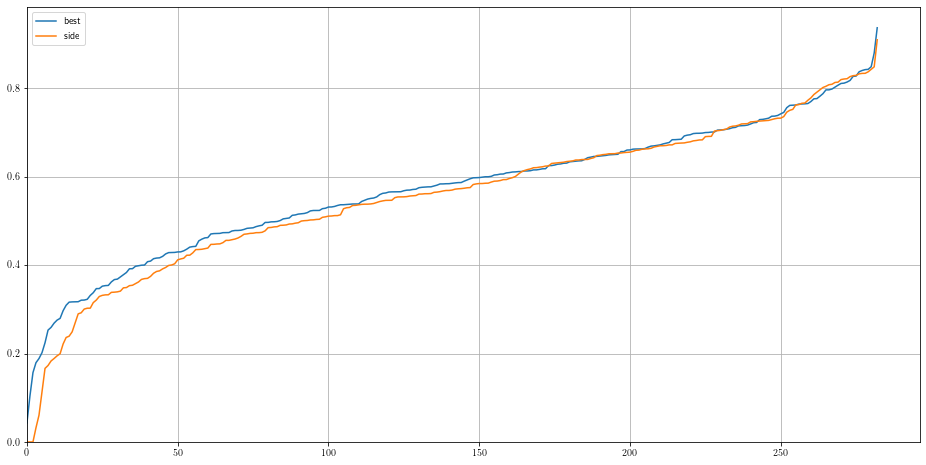

In [28]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 1, 1)
ax.plot(sorted(ious[0, :]), label='best')
ax.plot(sorted(ious[1, :]), label='side')
ax.grid()
ax.legend()
ax.set_xlim(0)
ax.set_ylim(0)

plt.show()

**NB** Такая модель работает несколько хуже, чем лучшая на данные момент. Тем не менее сделаем посылку, чтобы завалидировать качество модели.

In [29]:
subm = pd.read_parquet(join(DATADIR, 'test_data.parquet')) \
    .set_index(['item_id', 'user_id']) \
    .sort_index()

In [30]:
data_all = user.copy().append(subm).sort_index()
data_all[['x_cent', 'y_cent']] = data_all.apply(centering, axis=1, result_type='expand')
data_all.head()

x_min  y_min  x_max  y_max  x_cent  y_cent
item_id user_id                                            
5       141        210    925    483   1255   346.5  1090.0
        903        151    917    511   1160   331.0  1038.5
        1723       192    914    510   1331   351.0  1122.5
10      141         95    559    427    852   261.0   705.5
        903         72    570    420    858   246.0   714.0

In [31]:
target_all = true.copy().append(
    pd.DataFrame(data=[[0, 0, 0, 0] for _ in subm.index.levels[0]],
                 columns=subm.columns,
                 index=subm.index.levels[0]))
target_all[['x_cent', 'y_cent']] = target_all.apply(centering, axis=1, result_type='expand')
target_all['dx'] = target_all.x_max - target_all.x_min
target_all['dy'] = target_all.y_max - target_all.y_min
target_all.tail()

,x_min,y_min,x_max,y_max,x_cent,y_cent,dx,dy
item_id,,,,,,,,
35685,0,0,0,0,0.0,0.0,0,0
35695,0,0,0,0,0.0,0.0,0,0
35966,0,0,0,0,0.0,0.0,0,0
35973,0,0,0,0,0.0,0.0,0,0
35978,0,0,0,0,0.0,0.0,0,0


In [32]:
train_item_ids = true.index.values
test_item_ids = subm.index.levels[0].values

In [33]:
origin = fit_origin(data_all, target_all, train_item_ids, test_item_ids)
sides = fit_sides(data_all, origin, target_all, train_item_ids, test_item_ids)

boxes = pd.merge(origin, sides, how='right', left_index=True, right_index=True)
boxes['x_min'] = boxes.x_cent - boxes.dx / 2
boxes['x_max'] = boxes.x_cent + boxes.dx / 2
boxes['y_min'] = boxes.y_cent - boxes.dy / 2
boxes['y_max'] = boxes.y_cent + boxes.dy / 2
boxes = boxes.sort_index()
boxes.head()

,x_cent,y_cent,dx,dy,x_min,x_max,y_min,y_max
item_id,,,,,,,,
18,415.076493,886.821175,581.746671,488.239415,124.203157,705.949828,642.701468,1130.940883
19,86.937229,626.588853,114.565011,97.784931,29.654724,144.219735,577.696388,675.481319
33,227.805992,522.431683,333.058928,275.460281,61.276528,394.335456,384.701542,660.161824
62,332.948431,1056.952019,511.139386,460.490102,77.378738,588.518124,826.706968,1287.197070
114,138.614491,660.641151,176.771642,145.454123,50.228670,227.000312,587.914089,733.368213


In [34]:
boxes[['x_min', 'y_min', 'x_max', 'y_max']].to_csv(
    path_or_buf=join(DATADIR, 'submissions/submission023.csv'),
    header=False,
    index=True,
)

К сожаление посылка только улучшила второй результат.

## Предсказывание центра и сторон напрямую

Вместо того, чтобы предсказывать положение центра и размеры сторон последовательно двумя моделями, можно попытаться предсказать положение центра и размеры сторон напрямую.

In [35]:
def fit_direct(data_all, target_all, train_item_ids, test_item_ids):
    feats = data_all.copy() \
        .groupby('item_id') \
        .aggregate({'x_min': np.min,
                    'y_min': np.min,
                    'x_max': np.max,
                    'y_max': np.max,
                    'x_cent': np.mean,
                    'y_cent': np.mean})

    est = LinearRegression(
        normalize=True,
    ).fit(feats.loc[train_item_ids].values,
          target_all.loc[train_item_ids][['x_cent', 'y_cent', 'dx', 'dy']].values)

    res = pd.DataFrame(data=est.predict(feats.loc[test_item_ids].values),
                       index=test_item_ids,
                       columns=['x_cent', 'y_cent', 'dx', 'dy'])
    res.index.set_names('item_id', inplace=True)
    res['x_min'] = res.x_cent - res.dx / 2
    res['x_max'] = res.x_cent + res.dx / 2
    res['y_min'] = res.y_cent - res.dy / 2
    res['y_max'] = res.y_cent + res.dy / 2
    res = res.sort_index()
    
    iou = miou(res[['x_min', 'y_min', 'x_max', 'y_max']].reset_index(),
               target_all.loc[test_item_ids][['x_min', 'y_min', 'x_max', 'y_max']].reset_index())

    return iou, res[['x_min', 'y_min', 'x_max', 'y_max']].sort_index().copy()

In [36]:
ious = np.zeros(10, dtype=np.float)

for i in tqdm(range(ious.size), unit='attempt'):
    ious[i], _ = fit_direct(data_all.loc[train_item_ids].copy(),
                            target_all.loc[train_item_ids].copy(),
                            *train_test_split(train_item_ids, train_size=0.7))
    
print(f'{ious.mean():.7f} ± {ious.std()}')

100%|██████████| 10/10 [00:01<00:00,  7.06attempt/s]

0.5622137 ± 0.008767399346018279


**NB** Качество всё равно хуже, чем качество лучшей модели, но лучше, чем качество модели, предсказывающей центр и стороны последовательно. Здесь мы тоже попробуем завалидировать посылкой.

In [37]:
_, frame = fit_direct(data_all, target_all,
                      train_item_ids, test_item_ids)
frame.to_csv(join(DATADIR, 'submissions/submision024.csv'), index=True, header=False)

К сожалению, получилось улучшить лишь второй результат.

## Комментарии и обсуждение

Принципиально лучшего качество получить не удалось, но удалось приблизиться к лучшему решению на данные момент. Вероятно, что проблема, почему не получилось сделать лучше та же, что и в общем случае: недостаток данных и шумная выборка.